# Explorer les mots vecteurs


In [ ]:


import sys
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
%matplotlib inline



[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Vecteurs de mots

Les vecteurs de mots sont souvent utilisés comme un composant fondamental pour les tâches NLP en aval, par exemple la réponse aux questions, la génération de texte, la traduction, etc., il est donc important de se faire une idée de leurs forces et de leurs faiblesses. Ici, vous explorerez deux types de vecteurs de mots : ceux dérivés des *matrices de cooccurrence*, et ceux dérivés via *word2vec*.


## Partie 1 : Vecteurs de mots basés sur le comptage

La plupart des modèles de vecteurs de mots partent de l'idée suivante :

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

De nombreuses implémentations de vecteurs de mots reposent sur l'idée que des mots similaires, c'est-à-dire des (quasi) synonymes, seront utilisés dans des contextes similaires. Par conséquent, des mots similaires seront souvent prononcés ou écrits avec un sous-ensemble commun de mots, c'est-à-dire des contextes. En examinant ces contextes, nous pouvons essayer de développer des ancrages pour nos mots. En gardant cette intuition à l'esprit, de nombreuses approches "anciennes" de la construction de vecteurs de mots s'appuient sur le nombre de mots. Nous développons ici l'une de ces stratégies, les *matrices de cooccurrence*

### Cooccurrence

Une matrice de cooccurrence indique la fréquence de cooccurrence des éléments dans un environnement donné. Étant donné un mot $w_i$ apparaissant dans le document, nous considérons la *fenêtre de contexte* entourant $w_i$. En supposant que la taille de notre fenêtre fixe soit de $n$, il s'agit des $n$ mots précédents et $n$ mots suivants dans ce document, c'est-à-dire les mots $w_{i-n} \dots w_{i-1}$ et $w_{i+1} \dots w_{i+n}$. Nous construisons une *matrice de cooccurrence* $M$, qui est une matrice symétrique mot par mot dans laquelle $M_{ij}$ est le nombre de fois où $w_j$ apparaît dans la fenêtre de $w_i$.

**Exemple : Cooccurrence avec une fenêtre fixe de n=1** :

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | START | all | that | glitters | is   | not  | gold  | well | ends | END |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| START    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| END      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |



The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

<img src="https://drive.google.com/uc?export=view&id=1ZStSTmhf7zvG1QGh9NHVyOIKqR9i2xGk">

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*.



Nous utiliserons ici le corpus Reuters (actualités économiques et financières). Ce corpus se compose de 10 788 documents d'actualité totalisant 1,3 million de mots. Ces documents couvrent 90 catégories et sont divisés en deux catégories : formation et test. La fonction `read_corpus` ci-dessous extrait uniquement les articles de la catégorie "crude" (c'est-à-dire les articles sur le pétrole, le gaz, etc.). La fonction ajoute également des tokens START et END à chacun des documents, et met les mots en minuscules.

In [ ]:
START_TOKEN = '<START>'
END_TOKEN = '<END>'



In [ ]:
def read_corpus(category="crude"):
    """ Lire les fichiers de la catégorie Reuter's spécifiée.
        Params :
            category (string) : nom de la catégorie
        Retour :
            liste de listes, avec les mots de chacun des fichiers traités
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


In [ ]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

Nous allons écrire une méthode pour déterminer les mots distincts (types de mots) qui apparaissent dans le corpus.

In [ ]:
def distinct_words(corpus):
     """
       Détermine une liste de mots distincts pour le corpus.
        Params :
            corpus (liste de listes de chaînes) : corpus de documents
        Retourne :
            corpus_words (liste de chaînes) : liste de mots distincts dans le corpus, triée (en utilisant la fonction python 'sorted')
            num_corpus_words (entier) : nombre de mots distincts dans le corpus
     """
     corpus_words = sorted(list(set([word for words_list in corpus for word in words_list])))
     num_corpus_words = len(corpus_words)



     return corpus_words, num_corpus_words

In [ ]:
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]

print(distinct_words(test_corpus))

(['All', "All's", 'END', 'START', 'ends', 'glitters', 'gold', "isn't", 'that', 'well'], 10)


Nous allons écrire une méthode qui construit une matrice de cooccurrence pour une certaine taille de fenêtre $n$ (avec une valeur par défaut de 4), en considérant les mots $n$ avant et $n$ après le mot au centre de la fenêtre.

In [ ]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Calcule la matrice de cooccurrence pour le corpus donné et la taille de la fenêtre (4 par défaut).

        Note : Chaque mot d'un document doit être au centre d'une fenêtre. Les mots situés près des bords auront un
              plus petit nombre de mots cooccurrents.

              Par exemple, si nous prenons le document "START All that glitters is not gold END" avec une taille de fenêtre de 4,
              "All" cooccurera avec "START", "that", "glitters", "is", et "not".

        Params :
            corpus (liste de listes de chaînes) : corpus de documents
            window_size (int) : taille de la fenêtre contextuelle
        Retour :
            M (matrice numpy de forme (nombre de mots du corpus, nombre de mots du corpus)) :
                Matrice de cooccurrence des comptes de mots.
                L'ordre des mots dans les lignes/colonnes doit être le même que l'ordre des mots donné par la fonction distinct_words.
            word2Ind (dict) : dictionnaire qui associe un mot à un index (c'est-à-dire un numéro de ligne/colonne) pour la matrice M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}


    M = np.zeros((num_words, num_words))
    word2Ind = dict(zip(words, range(num_words)))

    for doc in corpus:
        current_idx = 0
        doc_len = len(doc)
        while current_idx < doc_len:
            left_boudary = max(current_idx-window_size, 0)
            right_boundary = min(current_idx+window_size+1, doc_len)
            outside_words = doc[left_boudary:current_idx] + doc[current_idx+1:right_boundary]
            center_word = doc[current_idx]
            center_idx = word2Ind[center_word]

            for outside_word in outside_words:
                outside_idx = word2Ind[outside_word]
                M[outside_idx, center_idx] += 1

            current_idx += 1

    return M, word2Ind

In [ ]:

test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

print(M_test)

[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1. 0.]]



Nous construirons une méthode qui réduit la dimensionnalité de la matrice afin de produire des enregistrements à k dimensions. Nous utiliserons la méthode SVD pour prendre les k premières composantes et produire une nouvelle matrice d'encastrements k-dimensionnels.



In [ ]:
def reduce_to_k_dim(M, k=2):
    """ Réduire une matrice de comptage des cooccurrences de dimensionnalité (num_corpus_mots, num_corpus_mots)
        en une matrice de dimensionnalité (num_corpus_mots, k) en utilisant la fonction SVD suivante de Scikit-Learn :
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params :
            M (matrice numpy de forme (nombre de mots du corpus, nombre de mots du corpus)) : matrice de cooccurrence du nombre de mots
            k (int) : taille d'intégration de chaque mot après réduction de la dimension
        Retour :
            M_reduced (numpy matrix of shape (number of corpus words, k)) : matrice de k-enchevêtrements de mots dimensionnels.
                    En termes de SVD du cours de mathématiques, cela renvoie en fait U * S
    """
    n_iters = 10     # Utilisez ce paramètre dans votre appel à `TruncatedSVD`
    M_reduced = None
    print("Exécution de la SVD tronquée sur %i mots..." % (M.shape[0]))


    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)



    return M_reduced

In [ ]:

test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

print(M_test_reduced)

Exécution de la SVD tronquée sur 10 mots...
[[ 7.05647176e-01  4.84057274e-01]
 [ 7.05647176e-01 -4.84057274e-01]
 [ 6.54802087e-01 -7.83221122e-01]
 [ 5.20200324e-01  2.42861287e-14]
 [ 1.02780472e+00 -1.93178806e-14]
 [ 6.54802087e-01  7.83221122e-01]
 [ 3.82258491e-01  6.56224003e-01]
 [ 3.82258491e-01 -6.56224003e-01]
 [ 1.39420808e+00 -1.06179274e+00]
 [ 1.39420808e+00  1.06179274e+00]]


Nous allons ici écrire une fonction permettant de tracer un ensemble de vecteurs 2D dans l'espace 2D. =

In [ ]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Tracer dans un nuage de points les encastrements des mots spécifiés dans la liste "words".
        NOTE : ne pas tracer tous les mots listés dans M_reduced / word2Ind.
        Inclure une étiquette à côté de chaque point.

        Params :
            M_reduced (matrice numpy de forme (nombre de mots uniques dans le corpus, k)) : matrice d'enchâssements de mots k-dimensioal
            word2Ind (dict) : dictionnaire qui associe les mots aux indices de la matrice M
            words (liste de chaînes de caractères) : mots dont nous voulons visualiser les enchâssements
    """


    x_coords = M_reduced[:, 0]
    y_coords = M_reduced[:, 1]

    for word in words:
        idx = word2Ind[word]
        embedding = M_reduced[idx]
        x = embedding[0]
        y = embedding[1]

        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)



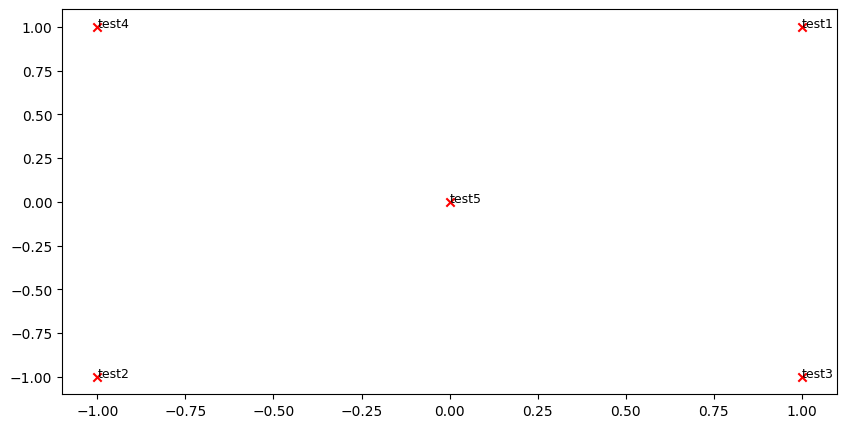

In [ ]:
M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)



Nous allons maintenant rassembler toutes les parties que vous avez écrites ! Nous allons calculer la matrice de cooccurrence avec une fenêtre fixe de 4, sur le corpus "brut" de Reuters. Ensuite, nous utiliserons TruncatedSVD pour calculer l'intégration bidimensionnelle de chaque mot. TruncatedSVD renvoie des U\*S, nous normalisons donc les vecteurs renvoyés, de sorte que tous les vecteurs apparaissent autour du cercle unitaire.

Exécution de la SVD tronquée sur 8185 mots...


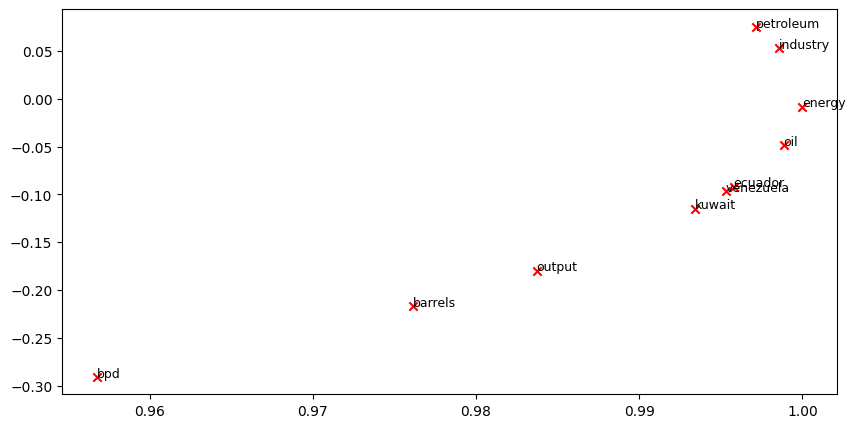

In [ ]:

reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rééchelonner (normaliser) les lignes pour qu'elles aient chacune une longueur unitaire
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

## Partie 3 : Vecteurs de mots basés sur la prédiction

Comme nous l'avons vu en classe, les vecteurs de mots basés sur la prédiction ont été récemment mis à la mode, par exemple word2vec. Ici, nous allons explorer les encastrements produits par word2vec.

In [ ]:
#Chargement des vecteurs Word2Vec
import gensim.downloader as api
wv_from_bin = api.load("word2vec-google-news-300")

In [ ]:
vocab = list(wv_from_bin.key_to_index.keys())

print("Taille du vocabulaire chargé %i" % len(vocab))

Taille du vocabulaire chargé 3000000


In [ ]:
wv_from_bin["leaves"].shape

(300,)

Comparons directement l'intégration de word2vec à celle de la matrice de cooccurrence.

In [ ]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Place les vecteurs word2vec dans une matrice M.
        Param :
            wv_from_bin : objet KeyedVectors ; les 3 millions de vecteurs word2vec chargés à partir d'un fichier
        Retourne :
            M : matrice numpy de forme (num words, 300) contenant les vecteurs
            word2Ind : dictionnaire associant chaque mot à son numéro de ligne dans M
    """
    import random
    words = list(wv_from_bin.key_to_index.keys())
    print("Mélanger les mots ...")
    random.shuffle(words)
    words = words[:10000]
    print("Placement de %i mots dans word2Ind et dans la matrice M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin[w])
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin[w])
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [ ]:

M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Mélanger les mots ...
Placement de 10000 mots dans word2Ind et dans la matrice M...
Done.
Exécution de la SVD tronquée sur 10010 mots...


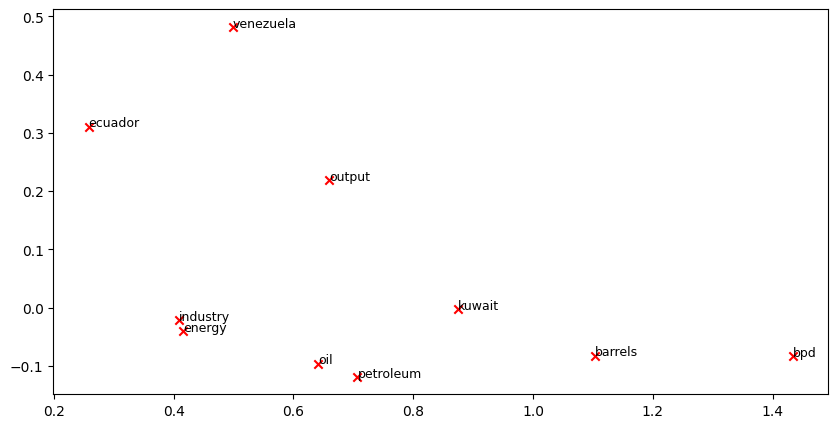

In [ ]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

### Cosine Similarity
Maintenant que nous disposons de vecteurs de mots, nous avons besoin d'un moyen de quantifier la similarité entre les mots individuels, en fonction de ces vecteurs. L'une de ces mesures est la similarité en cosinus. Nous l'utiliserons pour trouver les mots qui sont "proches" et "éloignés" les uns des autres.

Nous pouvons considérer les vecteurs à n dimensions comme des points dans un espace à n dimensions. Si nous adoptons cette perspective, les distances L1 et L2 permettent de quantifier l'espace "à parcourir" pour aller de l'un à l'autre de ces deux points. Une autre approche consiste à examiner l'angle entre deux vecteurs. La trigonométrie nous apprend que

<img src="https://drive.google.com/uc?export=view&id=1gc8ifRlJbzcjJGuswqwlt5Qqdg8taw-0" width=20% style="float: center;"></img>

Au lieu de calculer l'angle réel, nous pouvons laisser la similarité en termes de $similarité = cos(\Theta)$. Formellement, la [Similitude cosinusienne] (https://en.wikipedia.org/wiki/Cosine_similarity) $s$ entre deux vecteurs $p$ et $q$ est définie comme suit :

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$



### Mots polysémiques
nous essayons de trouver un mot polysémique (par exemple, "leaves" ou "scoop") tel que le top 10 des mots les plus similaires (selon la similarité cosinus) contienne des mots apparentés dans les deux sens. Par exemple, "leaves" contient à la fois "vanishes" et "stalks" dans le top 10, et "scoop" contient à la fois "handed_waffle_cone" et "lowdown".

In [ ]:

wv_from_bin.most_similar("leaves")


[('leaving', 0.5886486172676086),
 ('arrives', 0.5362045764923096),
 ('left', 0.522864580154419),
 ('Leaves', 0.5153513550758362),
 ('leave', 0.5131403803825378),
 ('departs', 0.510783314704895),
 ('lingers', 0.4776709973812103),
 ('vanishes', 0.4696614444255829),
 ('stalks', 0.46650534868240356),
 ('sends', 0.4623021185398102)]

### Synonyms & Antonyms

Lorsque l'on considère la similitude du cosinus, il est souvent plus pratique de penser à la distance du cosinus, qui est simplement 1 - similitude du cosinus.

Nous trouverons trois mots (w1,w2,w3) où w1 et w2 sont synonymes et w1 et w3 sont antonymes, mais la distance en cosinus (w1,w3) < la distance en cosinus (w1,w2). Par exemple, w1="happy" est plus proche de w3="sad" que de w2="joyful".


In [ ]:


w1 = "happy"
w2 = "joyful"
w3 = "sad"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Les synonymes {}, {} ont une distance en cosinus : {}".format(w1, w2, w1_w2_dist))
print("Les antonymes {}, {} ont une distance en cosinus : {}".format(w1, w3, w1_w3_dist))


Les synonymes happy, joyful ont une distance en cosinus : 0.5761803686618805
Les antonymes happy, sad ont une distance en cosinus : 0.46453857421875


### Résoudre des analogies avec des mots vecteurs

Il a été démontré que les vecteurs Word2Vec ont parfois la capacité de résoudre des analogies.

Par exemple, pour l'analogie "homme : roi : : femme : x", quel est x ?

Dans la cellule ci-dessous, nous vous montrons comment utiliser les vecteurs de mots pour trouver x. La fonction `most_similar` trouve les mots qui sont les plus similaires aux mots de la liste `positive` et les plus différents des mots de la liste `négative`. La réponse à l'analogie sera le mot le plus similaire (valeur numérique la plus élevée).

In [ ]:
# Exécutez cette cellule pour répondre à l'analogie -- homme : roi : : femme : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]


### Trouver des analogies
Nous trouverons un exemple d'analogie qui correspond à ces vecteurs (c'est-à-dire que le mot voulu est classé en tête).

In [ ]:
pprint.pprint(wv_from_bin.most_similar(positive=['purple', 'tomato'], negative=['red']))

[('tomatoes', 0.6614440679550171),
 ('lettuce', 0.6111559271812439),
 ('strawberries', 0.6029782891273499),
 ('strawberry', 0.6000961661338806),
 ('asparagus', 0.5944024324417114),
 ('watermelon', 0.5924463272094727),
 ('cherry_tomatoes', 0.5894373655319214),
 ('radishes', 0.5881099104881287),
 ('broccoli', 0.5862938761711121),
 ('rhubarb', 0.5825343132019043)]


### Analogie incorrecte
Nous allons essayer de trouver un exemple d'analogie qui ne tient pas selon ces vecteurs.

In [ ]:


pprint.pprint(wv_from_bin.most_similar(positive=['purple', 'apple'], negative=['red']))



[('apples', 0.5736606121063232),
 ('berry', 0.5442135334014893),
 ('Granny_Smiths', 0.5280871391296387),
 ('strawberry', 0.526979386806488),
 ('crumb_pie', 0.5259447693824768),
 ('pumpkin', 0.5254353880882263),
 ('berries', 0.5217612981796265),
 ('pear', 0.5118343830108643),
 ('jujubes', 0.5108941793441772),
 ('watermelon', 0.5093978643417358)]


###  Analyse guidée des biais dans les vecteurs de mots

Il est important d'être conscient des préjugés (genre, race, orientation sexuelle, etc.) implicites dans les mots intégrés.

Dans la cellule ci-dessous, nous examinons (a) quels termes sont les plus similaires à "femme" et "patron" et les plus dissemblables à "homme", et (b) quels termes sont les plus similaires à "homme" et "patron" et les plus dissemblables à "femme". Que trouvez-vous dans le top 10 ?

In [ ]:

pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'boss'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'boss'], negative=['woman']))

[('bosses', 0.5522644519805908),
 ('manageress', 0.49151360988616943),
 ('exec', 0.45940810441970825),
 ('Manageress', 0.4559843838214874),
 ('receptionist', 0.4474116563796997),
 ('Jane_Danson', 0.44480547308921814),
 ('Fiz_Jennie_McAlpine', 0.4427576959133148),
 ('Coronation_Street_actress', 0.44275563955307007),
 ('supremo', 0.4409853219985962),
 ('coworker', 0.43986251950263977)]

[('supremo', 0.6097397804260254),
 ('MOTHERWELL_boss', 0.5489562749862671),
 ('CARETAKER_boss', 0.5375303030014038),
 ('Bully_Wee_boss', 0.5333974957466125),
 ('YEOVIL_Town_boss', 0.5321705341339111),
 ('head_honcho', 0.5281980037689209),
 ('manager_Stan_Ternent', 0.525971531867981),
 ('Viv_Busby', 0.5256163477897644),
 ('striker_Gabby_Agbonlahor', 0.5250812768936157),
 ('BARNSLEY_boss', 0.5238943099975586)]
